In [1]:
import numpy as np

import pandas as pd

import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

from keras.utils import to_categorical

import joblib

In [2]:
df=pd.read_csv('/kaggle/input/eeg-data/preprocessed_dataset.csv')

df.head()

,# mean_0_a,mean_1_a,mean_2_a,mean_3_a,mean_4_a,mean_d_0_a,mean_d_1_a,mean_d_2_a,mean_d_3_a,mean_d_4_a,...,fft_741_b,fft_742_b,fft_743_b,fft_744_b,fft_745_b,fft_746_b,fft_747_b,fft_748_b,fft_749_b,label
0,4.62,30.3,-356.0,15.6,26.3,1.070,0.411,-15.70,2.06,3.15,...,23.5,20.3,20.3,23.5,-215.0,280.00,-162.00,-162.00,280.00,NEGATIVE
1,28.80,33.1,32.0,25.8,22.8,6.550,1.680,2.88,3.83,-4.82,...,-23.3,-21.8,-21.8,-23.3,182.0,2.57,-31.60,-31.60,2.57,NEUTRAL
2,8.90,29.4,-416.0,16.7,23.7,79.900,3.360,90.20,89.90,2.03,...,462.0,-233.0,-233.0,462.0,-267.0,281.00,-148.00,-148.00,281.00,POSITIVE
3,14.90,31.6,-143.0,19.8,24.3,-0.584,-0.284,8.82,2.30,-1.97,...,299.0,-243.0,-243.0,299.0,132.0,-12.40,9.53,9.53,-12.40,POSITIVE
4,28.30,31.3,45.2,27.3,24.5,34.800,-5.790,3.06,41.40,5.52,...,12.0,38.1,38.1,12.0,119.0,-17.60,23.90,23.90,-17.60,NEUTRAL


/tmp/ipykernel_24/3239923930.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_encoded = df.replace(encode)


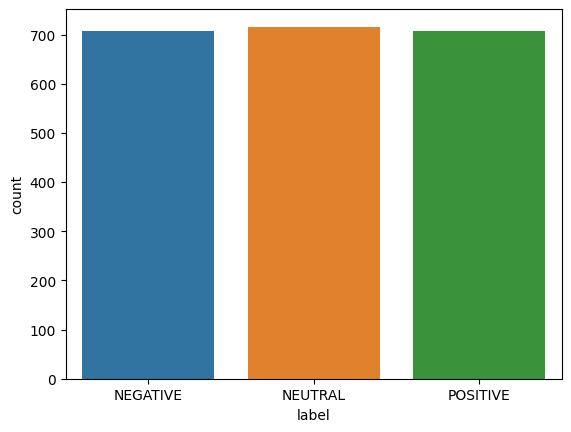

In [3]:
sns.countplot(x='label', data=df)



# df.isnull().sum().sum()



encode = ({'NEUTRAL': 0, 'POSITIVE': 1, 'NEGATIVE': 0} )

df_encoded = df.replace(encode)



X=df_encoded.drop(["label"]  ,axis=1)

y = df_encoded.loc[:,'label'].values

In [4]:
X_orig=df_encoded.drop(["label"]  ,axis=1)

y_orig = to_categorical(df_encoded.loc[:,'label'].values)

print(X_orig.shape)

print(y_orig.shape)

(2132, 2548)
(2132, 2)


In [5]:
scaler = StandardScaler()

scaler.fit(X)

X = scaler.transform(X)

y = to_categorical(y)

# print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print(X_train.shape)

#X_train = np.reshape(X_train, (X_train.shape[0],1,X.shape[1]))

#X_test = np.reshape(X_test, (X_test.shape[0],1,X.shape[1]))

print(f"X_train  shape: {X_train.shape}")

print(f"X_test  shape: {X_test.shape}")

print(y_train.shape)  # Should be (num_samples, num_classes)

print(y_test.shape)


(1705, 2548)
X_train  shape: (1705, 2548)
X_test  shape: (427, 2548)
(1705, 2)
(427, 2)


In [6]:
import numpy as np

import tensorflow as tf

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout

from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, confusion_matrix

from tensorflow.keras.layers import LSTM
from keras.optimizers import Adam

tf.keras.backend.clear_session()


In [7]:
from keras.layers import Flatten



def get_nn_model(input_shape, num_neurons, dropout_rate):

    model = Sequential([

        Flatten(input_shape=input_shape),  # Flatten the input

        Dense(num_neurons, activation='relu'),

        Dropout(dropout_rate),

        Dense(num_neurons // 2, activation='relu'),

        Dropout(dropout_rate),

        Dense(y_train.shape[1], activation='sigmoid')  # Binary classification

    ])

    return model



input_shape = (1, 2548)  # Updated to match the shape of your input data

model = get_nn_model(input_shape, num_neurons=64, dropout_rate=0.5)


/opt/conda/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
def fitness_function(params, X_train, y_train, X_val, y_val):

    learning_rate, num_neurons, dropout_rate, batch_size = params

    input_shape = (X_train.shape[1],)

    

    # Create model

    model = get_nn_model(input_shape, int(num_neurons), dropout_rate)

    

    # Compile with optimizer using the tunable learning rate

    optimizer = Adam(learning_rate=learning_rate)

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    

    # Train the model

    model.fit(X_train, y_train, epochs=10, batch_size=int(batch_size), verbose=2)

    

    # Evaluate on validation set

    score, acc = model.evaluate(X_val, y_val, verbose=0)

    

    return -acc  # PSO minimizes the function, so we return negative accuracy to maximize it


In [9]:
def pso_optimization(X_train, y_train, X_val, y_val, bounds, num_particles, max_iter):

    dim = len(bounds)

    # Initialize particles' positions and velocities

    particles = np.random.rand(num_particles, dim)

    velocities = np.random.rand(num_particles, dim) * 0.1

    personal_best = particles.copy()

    personal_best_fitness = np.array([fitness_function(p, X_train, y_train, X_val, y_val) for p in personal_best])

    global_best = personal_best[np.argmin(personal_best_fitness)]



    # PSO main loop

    for i in range(max_iter):

        for j in range(num_particles):

            velocities[j] = 0.5 * velocities[j] + np.random.rand() * (personal_best[j] - particles[j]) + np.random.rand() * (global_best - particles[j])

            particles[j] += velocities[j]

            particles[j] = np.clip(particles[j], bounds[:, 0], bounds[:, 1])  # Ensure within bounds



            # Evaluate new positions

            current_fitness = fitness_function(particles[j], X_train, y_train, X_val, y_val)

            if current_fitness < personal_best_fitness[j]:

                personal_best[j] = particles[j]

                personal_best_fitness[j] = current_fitness

                if current_fitness < fitness_function(global_best, X_train, y_train, X_val, y_val):

                    global_best = particles[j]



    return global_best


In [10]:
# Assume X_train, X_val, y_train, y_val are already preprocessed EEG data

input_shape = (X_train.shape[1],)  # Input shape for the fully connected layers



# Hyperparameter bounds: [learning_rate, num_neurons, dropout_rate, batch_size]

bounds = np.array([[1e-5, 1e-2], [64, 128], [0.2, 0.6], [16, 64]])  # Example ranges



# Perform PSO optimization

best_params = pso_optimization(X_train, y_train, X_test, y_test, bounds, num_particles=10, max_iter=20)



print(f"Best hyperparameters found: Learning rate: {best_params[0]}, Neurons: {int(best_params[1])}, "

      f"Dropout rate: {best_params[2]}, Batch size: {int(best_params[3])}")


Epoch 1/10


I0000 00:00:1730702925.832310      69 service.cc:145] XLA service 0x7ab8f8004700 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730702925.832370      69 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1730702925.832375      69 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1730702926.570445      69 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


54/54 - 2s - 39ms/step - accuracy: 0.6645 - loss: 0.6531
Epoch 2/10
54/54 - 0s - 2ms/step - accuracy: 0.6645 - loss: 0.6479
Epoch 3/10
54/54 - 0s - 2ms/step - accuracy: 0.6528 - loss: 0.6534
Epoch 4/10
54/54 - 0s - 2ms/step - accuracy: 0.6645 - loss: 0.6466
Epoch 5/10
54/54 - 0s - 2ms/step - accuracy: 0.6645 - loss: 0.6480
Epoch 6/10
54/54 - 0s - 2ms/step - accuracy: 0.6645 - loss: 0.6451
Epoch 7/10
54/54 - 0s - 2ms/step - accuracy: 0.6645 - loss: 0.6431
Epoch 8/10
54/54 - 0s - 2ms/step - accuracy: 0.6528 - loss: 0.6531
Epoch 9/10
54/54 - 0s - 2ms/step - accuracy: 0.6645 - loss: 0.6483
Epoch 10/10
54/54 - 0s - 2ms/step - accuracy: 0.6481 - loss: 0.6509
Epoch 1/10
54/54 - 1s - 27ms/step - accuracy: 0.6645 - loss: 0.6409
Epoch 2/10
54/54 - 0s - 2ms/step - accuracy: 0.6645 - loss: 0.6391
Epoch 3/10
54/54 - 0s - 2ms/step - accuracy: 0.6645 - loss: 0.6395
Epoch 4/10
54/54 - 0s - 2ms/step - accuracy: 0.6645 - loss: 0.6393
Epoch 5/10
54/54 - 0s - 2ms/step - accuracy: 0.6645 - loss: 0.6434
Epo

In [11]:
def train_model_with_best_params(best_params, X_train, y_train, X_val, y_val):
    learning_rate = best_params[0]
    num_neurons = int(best_params[1])
    dropout_rate = best_params[2]
    batch_size = int(best_params[3])

    # Build the model with the best parameters
    model = get_nn_model(input_shape, num_neurons, dropout_rate)
    
    # Compile the model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model
    model.fit(X_train, y_train, batch_size=batch_size, epochs=20, validation_data=(X_val, y_val), verbose=0)
    
    # Evaluate the model
    score, acc = model.evaluate(X_val, y_val)
    print(f"Accuracy after tuning: {acc}")
    
    # Predict classes and calculate confusion matrix
    pred = model.predict(X_val)
    predict_classes = np.argmax(pred, axis=1)
    expected_classes = np.argmax(y_val, axis=1)
    conf_matrix = confusion_matrix(expected_classes, predict_classes)
    
    print("Confusion Matrix: \n", conf_matrix)

In [12]:
train_model_with_best_params(best_params, X_train, y_train, X_test, y_test)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9954 - loss: 0.0250
Accuracy after tuning: 0.9906322956085205
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Confusion Matrix: 
 [[290   1]
 [  3 133]]
